# Verify Training Pipeline

I will make sure that we can load the data correctly.

In [1]:
%load_ext autoreload
%autoreload 2
%pdb on 

from pathlib import Path
from tqdm import tqdm
from random import *
from datetime import *
from IPython.core.debugger import set_trace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import *
import rasterio as rio
import geopandas as gpd

Automatic pdb calling has been turned ON


In [2]:
from flow.config import TrainerConfig
from flow.datamodules import get_datamodule

We create a simple configuration for testing:

In [3]:
class SimpleConfig:
    """Simple configuration object for testing purposes."""
    
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [4]:
# Let's create a configuration with earth_surface_water dataset
config = SimpleConfig(
    dataset="earth_surface_water",  # Use the earth surface water dataset
    batch_size=8,                   # We want to visualize 8 items
    num_workers=0,                  # Number of workers for data loading
    image_size=(224, 224),          # Resize images to this size
    normalize=True,                 # Apply normalization
    val_ratio=0.2,                  # Validation split ratio
    seed=42                         # Random seed for reproducibility
)

In [5]:
# Create a datamodule using the configuration
print("Creating datamodule...")
datamodule = get_datamodule("segmentation", config)

Creating datamodule...


In [6]:
# Set up the datamodule
print("Setting up datamodule...")
datamodule.setup()

Setting up datamodule...


In [7]:
# Get the training dataloader
print("Getting training dataloader...")
train_loader = datamodule.train_dataloader()

Getting training dataloader...


In [8]:
# Get a single batch from the dataloader
print("Getting a batch from the dataloader...")
batch = next(iter(train_loader))

# Check what's in the batch
print(f"Batch keys: {batch.keys()}")
print(f"Input shape: {batch['image'].shape}")
print(f"Target shape: {batch['mask'].shape if 'mask' in batch else 'No mask found'}")

Getting a batch from the dataloader...
Batch keys: dict_keys(['image', 'mask'])
Input shape: torch.Size([8, 1, 6, 224, 224])
Target shape: torch.Size([8, 1, 224, 224])


Now let's visualize the examples:

In [24]:
def visualize_batch(batch, num_samples=8, figsize=(15, 8)):
    """
    Visualize a batch of images and their corresponding masks with specific reshaping.
    
    Args:
        batch: Dictionary containing 'image' and 'mask' tensors
        num_samples: Number of samples to visualize
        figsize: Figure size
    """
    # Get the images and masks
    images = batch['image'][:num_samples]  # Shape: [batch, 1, 6, 224, 224]
    masks = batch['mask'][:num_samples]    # Shape: [batch, 1, 224, 224]
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, num_samples, figsize=figsize)
    
    # Display the images
    for i in range(num_samples):
        # Get and reshape the image
        img = images[i].squeeze(0)        # Remove extra dimension -> [6, 224, 224]
        img = img.permute(1, 2, 0).cpu().numpy()  # -> [224, 224, 6]

        # Perform min-max normalization on the image
        img_min = img.min()
        img_max = img.max()
        if img_max > img_min:  # Avoid division by zero
            img = (img - img_min) / (img_max - img_min)
        
        # Take first 3 channels for RGB visualization
        img_rgb = img[:, :, :3]
            
        # Normalize for display
        if img_rgb.max() > 1.0:
            img_rgb = img_rgb / 255.0
        img_rgb = np.clip(img_rgb, 0, 1)
        
        # Display the image
        axes[0, i].imshow(img_rgb)
        axes[0, i].set_title(f"Sample {i+1}")
        axes[0, i].axis('off')
        
        # Get and reshape the mask
        mask = masks[i].squeeze().cpu().numpy()  # -> [224, 224]
        
        # Display the mask
        axes[1, i].imshow(mask, cmap='viridis')
        axes[1, i].set_title(f"Mask {i+1}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

Visualizing batch...


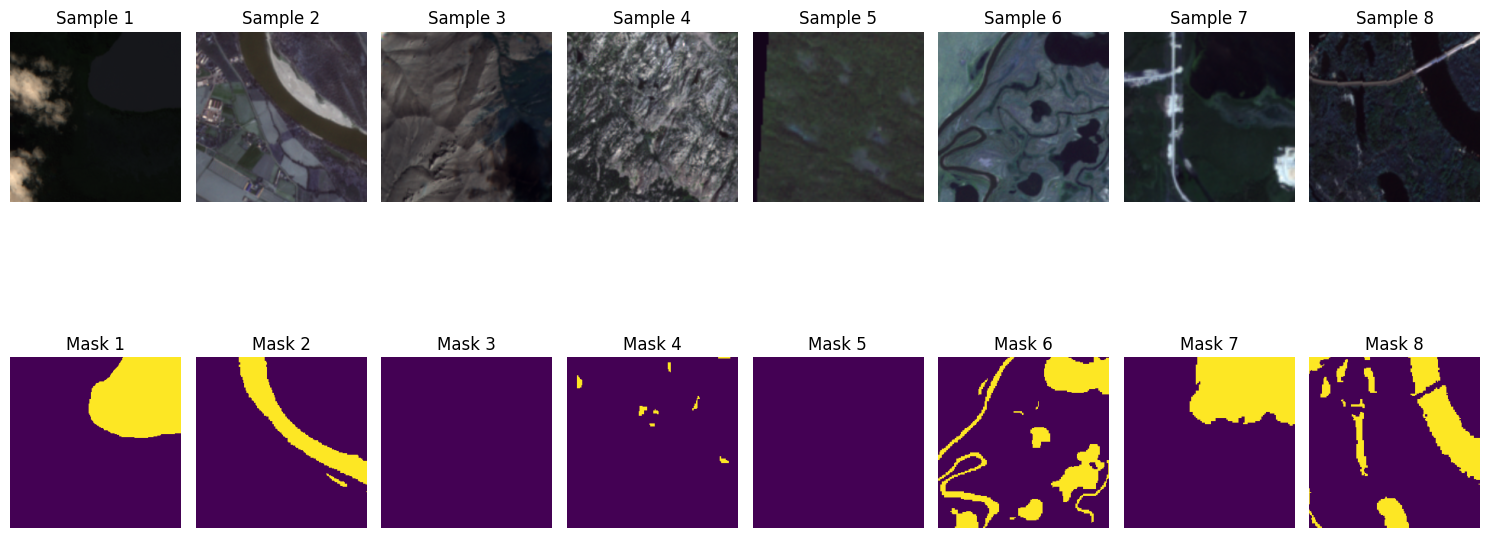

Training dataset size: 156
Validation dataset size: 38
Dataset type: <class 'torch.utils.data.dataset.Subset'>


In [25]:
# Visualize the batch
print("Visualizing batch...")
visualize_batch(batch)

# Display information about the dataset
print(f"Training dataset size: {len(datamodule.train_dataset)}")
print(f"Validation dataset size: {len(datamodule.val_dataset)}")

# Explore the dataset class
print(f"Dataset type: {type(datamodule.train_dataset)}")

---